In [1]:
import numpy as np
import ROOT as rt
import uproot
import h5py
import matplotlib.pyplot as plt
import os

Welcome to JupyROOT 6.12/07


In [2]:
base_dir = '/home/users/woodson/COMBINE/CMSSW_10_2_13/src/Kinga/bin_count/minl1l2_loss/q1'
combine_dir = os.path.join(base_dir,'combine')
!mkdir -p $combine_dir
!rm $combine_dir/*

In [3]:
qr_test_share = 0.7
h5file = h5py.File(os.path.join(base_dir, 'sel_bin_count_run_101_tsz30pc_q1.0.h5'))
print(h5file.keys())
qcd_xsec = 8.73e6 #8730000. # fb (mb in spreadsheet is millibarn)
qcd_gen_events = qr_test_share*79840374 # 50% of qcd events are used
sig_xsec = 1000. # fb
sig_gen_events = 536436 # all sig events are used
lumi = qcd_gen_events/qcd_xsec #assuming 1/fb
sig_inj_vals = np.linspace(0,1,11)

print(sig_inj_vals)

qcd_counts = h5file.get('qcdSigAllReco')
sig_counts = h5file.get('GtoWW35naReco')
qcd_tot, qcd_acc, qcd_rej = qcd_counts[0], qcd_counts[1], qcd_counts[2]
sig_tot, sig_acc, sig_rej = sig_counts[0], sig_counts[1], sig_counts[2]
bin_edges = h5file.get('bin_edges')

qcd_tot = qcd_tot*qcd_xsec*lumi/qcd_gen_events
qcd_acc = qcd_acc*qcd_xsec*lumi/qcd_gen_events
qcd_rej = qcd_rej*qcd_xsec*lumi/qcd_gen_events
sig_tot = sig_tot*sig_xsec*lumi/sig_gen_events
sig_acc = sig_acc*sig_xsec*lumi/sig_gen_events
sig_rej = sig_rej*sig_xsec*lumi/sig_gen_events

# exclude the last bin
n_bins = len(bin_edges)-2
max_bin = bin_edges[-2]
min_bin = bin_edges[0]

[u'GtoWW15naReco', u'GtoWW25naReco', u'GtoWW35naReco', u'GtoWW45naReco', u'bin_count_labels', u'bin_edges', u'qcdSigAllReco']
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [4]:
# prepare histograms and scale
background_hist_acc = rt.TH1D('background_acc','background_acc', n_bins, min_bin, max_bin)
signal_hist_acc = rt.TH1D('signal_acc','signal_acc', n_bins, min_bin, max_bin)
data_hist_acc = rt.TH1D('data_obs_acc','data_obs_acc', n_bins, min_bin, max_bin)

background_hist_rej = rt.TH1D('background_rej','background_rej', n_bins, min_bin, max_bin)
signal_hist_rej = rt.TH1D('signal_rej','signal_rej', n_bins, min_bin, max_bin)
data_hist_rej = rt.TH1D('data_obs_rej','data_obs_rej', n_bins, min_bin, max_bin)

for i, b in enumerate(qcd_acc):
    background_hist_acc.SetBinContent(i+1, b)
    data_hist_acc.SetBinContent(i+1, b)
for i, s in enumerate(sig_acc):
    signal_hist_acc.SetBinContent(i+1, s)
for i, b in enumerate(qcd_rej):
    background_hist_rej.SetBinContent(i+1, b)
    data_hist_rej.SetBinContent(i+1, b)
for i, s in enumerate(sig_rej):
    signal_hist_rej.SetBinContent(i+1, s)
# at this point, data_hist_* == qcd_hist_*

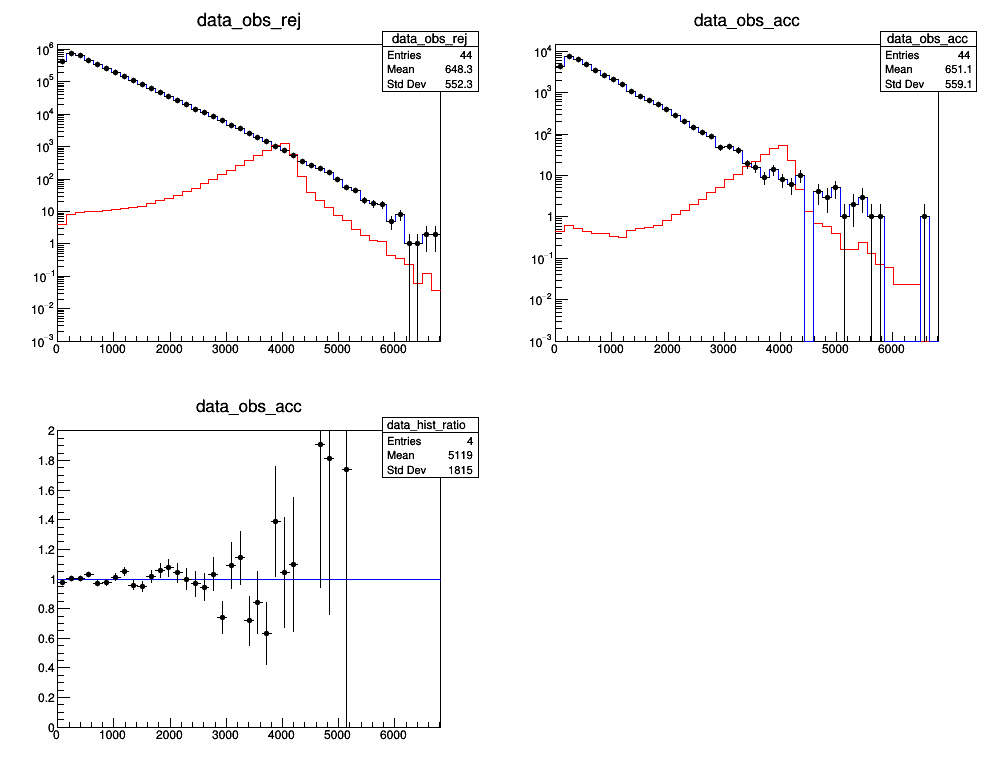

In [5]:
# plot background, signal, data
c = rt.TCanvas('c','c',1000,800)
c.Divide(2,2)

c.cd(1)
rt.gPad.SetLogy()
data_hist_rej.SetMinimum(0.001)
data_hist_rej.Draw('pez')
background_hist_rej.SetLineColor(rt.kBlue)
background_hist_rej.Draw('histsame')
signal_hist_rej.SetLineColor(rt.kRed)
signal_hist_rej.Draw('histsame')
data_hist_rej.SetLineColor(rt.kBlack)
data_hist_rej.SetMarkerColor(rt.kBlack)
data_hist_rej.SetMarkerStyle(20)
data_hist_rej.SetMarkerSize(0.5)
data_hist_rej.Draw('pezsame')

c.cd(2)
rt.gPad.SetLogy()
data_hist_acc.Draw('pez')
data_hist_acc.SetMinimum(0.001)
signal_hist_acc.SetLineColor(rt.kRed)
signal_hist_acc.Draw('histsame')
background_hist_acc.SetLineColor(rt.kBlue)
background_hist_acc.Draw('histsame')

data_hist_acc.SetLineColor(rt.kBlack)
data_hist_acc.SetMarkerColor(rt.kBlack)
data_hist_acc.SetMarkerStyle(20)
data_hist_acc.SetMarkerSize(0.5)
data_hist_acc.Draw('pezsame')

c.cd(3)
data_hist_acc.Sumw2()
data_hist_ratio = data_hist_acc.Clone('data_hist_ratio')
data_hist_rej.Sumw2()
data_hist_ratio.Divide(data_hist_rej)
data_hist_ratio.Scale(data_hist_rej.Integral()/data_hist_acc.Integral())
data_hist_ratio.Draw('pez')
data_hist_ratio.SetMaximum(2)
data_hist_ratio.SetMinimum(0)
tline = rt.TLine(min_bin, 1, max_bin, 1)
tline.SetLineColor(rt.kBlue)
tline.Draw()
data_hist_ratio.Draw('pezsame')
c.Draw()

In [6]:
# set up workspace
datacard_ws = rt.TFile.Open(os.path.join(combine_dir,'datacard_ws.root'),'recreate')
w = rt.RooWorkspace('w','w')
x = rt.RooRealVar('x','x',min_bin,max_bin)
w.factory('x[%.1f,%.1f]'%(min_bin, max_bin))

acc_bin_functions = rt.RooArgList()
rej_bin_functions = rt.RooArgList()
w.factory('eff[%f,0,1]'%(background_hist_acc.Integral()/background_hist_rej.Integral()))
w.var('eff').setConstant(False)

empty_hist = rt.TH1D('empty_hist','empty_hist', n_bins, min_bin, max_bin)
for iBinX in range(1,n_bins+1):
    empty_hist.SetBinContent(iBinX,1)
    w.factory('crBin%i_In[%.1f]'%(iBinX,background_hist_rej.GetBinContent(iBinX)))
    w.factory('crBin%i[0,-100,100]'%(iBinX))
    w.var('crBin%i_In'%iBinX).setConstant(True)
    w.var('crBin%i'%iBinX).setConstant(False)
    if background_hist_rej.GetBinContent(iBinX) > 0:
        w.factory("expr::crBin%iFunc('max(0,@0*pow(1.0+%f,@1))',crBin%i_In,crBin%i)"%(iBinX,1/rt.TMath.Sqrt(background_hist_rej.GetBinContent(iBinX)),iBinX,iBinX))
        w.factory("expr::bin%iFunc('max(0,@0*@1)',eff,crBin%iFunc)"%(iBinX,iBinX))
        rej_bin_functions.add(w.function('crBin%iFunc'%iBinX))
        acc_bin_functions.add(w.function('bin%iFunc'%iBinX))
    else:
        # instead
        #w.factory("expr::crBin%iFunc('max(0,@0))',crBin%i)"%(iBinX,iBinX))
        #w.factory("expr::bin%iFunc('max(0,@0*@1)',eff,crBin%i)"%(iBinX,iBinX))
        #rej_bin_functions.add(w.function('crBin%iFunc'%iBinX))
        #acc_bin_functions.add(w.function('bin%iFunc'%iBinX))
        # instead add consant variables that are just 0 to both acc and rej
        w.factory('srBin%i_In[%.1f]'%(iBinX,0))
        w.var('srBin%i_In'%iBinX).setConstant(True)
        rej_bin_functions.add(w.var('crBin%i_In'%iBinX))
        acc_bin_functions.add(w.var('srBin%i_In'%iBinX))
    
qcd_rph_rej = rt.RooParametricHist('background_rej','background_acc',w.var('x'),rej_bin_functions,empty_hist)
qcd_rph_rej_norm = rt.RooAddition('background_rej_norm','background_rej_norm',rej_bin_functions)
qcd_rph_acc = rt.RooParametricHist('background_acc','background_acc',w.var('x'),acc_bin_functions,empty_hist)
qcd_rph_acc_norm = rt.RooAddition('background_acc_norm','background_acc_norm',acc_bin_functions)
getattr(w,'import')(qcd_rph_rej, rt.RooCmdArg())
getattr(w,'import')(qcd_rph_rej_norm, rt.RooFit.RecycleConflictNodes())
getattr(w,'import')(qcd_rph_acc, rt.RooCmdArg())
getattr(w,'import')(qcd_rph_acc_norm, rt.RooFit.RecycleConflictNodes())

ds_signal_acc = rt.RooDataHist('signal_acc','signal_acc',rt.RooArgList(w.var('x')),signal_hist_acc)
ds_signal_rej = rt.RooDataHist('signal_rej','signal_rej',rt.RooArgList(w.var('x')),signal_hist_rej)
getattr(w,'import')(ds_signal_acc, rt.RooCmdArg())
getattr(w,'import')(ds_signal_rej, rt.RooCmdArg())


# inject signal to background histograms
for sig_inj in sig_inj_vals:
    sig_inj_str = '%.3f'%sig_inj
    sig_inj_str = sig_inj_str.replace('.','p')
    data_hist_rej_inj = data_hist_rej.Clone()
    data_hist_acc_inj = data_hist_acc.Clone()
    data_hist_rej_inj.Add(signal_hist_rej,sig_inj)
    data_hist_acc_inj.Add(signal_hist_acc,sig_inj)

    ds_data_acc = rt.RooDataHist('data_obs_inj%s_acc'%sig_inj_str,'data_obs_inj%s_acc'%sig_inj_str,rt.RooArgList(w.var('x')),data_hist_acc_inj)
    ds_data_rej = rt.RooDataHist('data_obs_inj%s_rej'%sig_inj_str,'data_obs_inj%s_rej'%sig_inj_str,rt.RooArgList(w.var('x')),data_hist_rej_inj)
    getattr(w,'import')(ds_data_acc, rt.RooCmdArg())
    getattr(w,'import')(ds_data_rej, rt.RooCmdArg())

datacard_ws.cd()
w.Write()
datacard_ws.Close()

w.Print('v')

[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing RooParametricHist::background_rej
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing RooAddition::background_rej_norm
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) using existing copy of RooFormulaVar::crBin1Func for import of RooAddition::background_rej_norm
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) using existing copy of RooRealVar::crBin1_In for import of RooAddition::background_rej_norm
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) using existing copy of RooRealVar::crBin1 for import of RooAddition::background_rej_norm
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) using existing copy of RooFormulaVar::crBin2Func for import of RooAddition::background_rej_norm
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) using existing copy of RooRealVar::crBin2_In for import of RooAddition::background_rej_norm
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) using existing copy of RooRealVa

In [7]:
os.chdir(combine_dir)
print(os.getcwd())

/home/users/woodson/COMBINE/CMSSW_10_2_13/src/Kinga/bin_count/minl1l2_loss/q1/combine


In [8]:
# datacard template
# no background normalization uncertainty

datacard_ratio = \
'''
imax 1
jmax 1
kmax *
---------------
shapes * * datacard_ws.root w:$PROCESS_$CHANNEL w:$PROCESS_$CHANNEL_$SYSTEMATIC
---------------
bin {BIN}
observation {OBS}
------------------------------
bin             {BIN}      {BIN}
process         signal     background
process         0          1
rate            {SIGRATE}    {BKGRATE}
--------------------------------
lumi lnN 1.01 -
eff   flatParam
'''

for i in range(1,n_bins+1):
    datacard_ratio += 'crBin%i   flatParam\n'%i

In [9]:
# write datacard
datacard_ratio_acc = datacard_ratio.format(BIN='acc',
                          OBS=-1,
                          BKGRATE=1,
                          SIGRATE=signal_hist_acc.Integral())
print(datacard_ratio_acc)
with open('datacard_ratio_acc.txt','w') as f:
    f.write(datacard_ratio_acc)
    
    
datacard_ratio_rej = datacard_ratio.format(BIN='rej',
                          OBS=-1,
                          BKGRATE=1,
                          SIGRATE=signal_hist_rej.Integral())
print(datacard_ratio_rej)
with open('datacard_ratio_rej.txt','w') as f:
    f.write(datacard_ratio_rej)


imax 1
jmax 1
kmax *
---------------
shapes * * datacard_ws.root w:$PROCESS_$CHANNEL w:$PROCESS_$CHANNEL_$SYSTEMATIC
---------------
bin acc
observation -1
------------------------------
bin             acc      acc
process         signal     background
process         0          1
rate            238.311368435    1
--------------------------------
lumi lnN 1.01 -
eff   flatParam
crBin1   flatParam
crBin2   flatParam
crBin3   flatParam
crBin4   flatParam
crBin5   flatParam
crBin6   flatParam
crBin7   flatParam
crBin8   flatParam
crBin9   flatParam
crBin10   flatParam
crBin11   flatParam
crBin12   flatParam
crBin13   flatParam
crBin14   flatParam
crBin15   flatParam
crBin16   flatParam
crBin17   flatParam
crBin18   flatParam
crBin19   flatParam
crBin20   flatParam
crBin21   flatParam
crBin22   flatParam
crBin23   flatParam
crBin24   flatParam
crBin25   flatParam
crBin26   flatParam
crBin27   flatParam
crBin28   flatParam
crBin29   flatParam
crBin30   flatParam
crBin31   flatParam
crBin

In [10]:
get_ipython().system(u'combineCards.py rej=datacard_ratio_rej.txt acc=datacard_ratio_acc.txt > datacard_ratio.txt')

from subprocess import Popen
import shlex 

for sig_inj in sig_inj_vals: 
    sig_inj_str = '%.3f'%sig_inj
    sig_inj_str = sig_inj_str.replace('.','p')
    
    # get obseverved goodness of fit test statistic (signal strength = 0)
    get_ipython().system('combine -M GoodnessOfFit --algo saturated --fixedSignalStrength 0 -d datacard_ratio.txt -n Ratio_inj%s --dataset data_obs_inj%s'%(sig_inj_str,sig_inj_str))
    # get significance p-value (for the known signal)
    get_ipython().system('combine -M Significance --pvalue -d datacard_ratio.txt -n Ratio_inj%s -t -1 --setParameters r=%.3f --dataset data_obs_inj%s --uncapped 1'%(sig_inj_str,sig_inj,sig_inj_str))

    #processes = []
    ## get expected goodness of fit test statistic distribution from frequentist toys
    #for i in range(10):
    #    command = 'combine -M GoodnessOfFit --algo saturated --fixedSignalStrength 0 -d datacard_ratio.txt -t 200 --toysFreq -n Ratio_inj%i  --dataset data_obs_inj%i -s %i'%(sig_inj,sig_inj,40+i)
    #    processes.append(Popen(shlex.split(command)))
    #    #get_ipython().system('combine -M GoodnessOfFit --algo saturated --fixedSignalStrength 0 -d datacard_ratio.txt -t 100 --toysFreq -n Ratio_inj%i  --dataset data_obs_inj%i -s %i'%(sig_inj,sig_inj,40+i))
    #for p in processes:
    #    p.wait()
    #get_ipython().system('hadd -f higgsCombineRatio_inj%i.GoodnessOfFit.mH120.123456.root higgsCombineRatio_inj%i.GoodnessOfFit.mH120.4*.root'%(sig_inj,sig_inj))
    

 <<< Combine >>> 
Will use saturated models to compute goodness of fit for a binned likelihood
>>> method used is GoodnessOfFit
>>> random number generator seed is 123456
Object crBin1Func is duplicated
Object crBin2Func is duplicated
Object crBin3Func is duplicated
Object crBin4Func is duplicated
Object crBin5Func is duplicated
Object crBin6Func is duplicated
Object crBin7Func is duplicated
Object crBin8Func is duplicated
Object crBin9Func is duplicated
Object crBin10Func is duplicated
Object crBin11Func is duplicated
Object crBin12Func is duplicated
Object crBin13Func is duplicated
Object crBin14Func is duplicated
Object crBin15Func is duplicated
Object crBin16Func is duplicated
Object crBin17Func is duplicated
Object crBin18Func is duplicated
Object crBin19Func is duplicated
Object crBin20Func is duplicated
Object crBin21Func is duplicated
Object crBin22Func is duplicated
Object crBin23Func is duplicated
Object crBin24Func is duplicated
Object crBin25Func is duplicated
Object crBin2

RooSimultaneousOpt: number of channel masks must equal number of channels

 --- GoodnessOfFit --- 
Best fit test statistic: 82.277
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456
Object crBin1Func is duplicated
Object crBin2Func is duplicated
Object crBin3Func is duplicated
Object crBin4Func is duplicated
Object crBin5Func is duplicated
Object crBin6Func is duplicated
Object crBin7Func is duplicated
Object crBin8Func is duplicated
Object crBin9Func is duplicated
Object crBin10Func is duplicated
Object crBin11Func is duplicated
Object crBin12Func is duplicated
Object crBin13Func is duplicated
Object crBin14Func is duplicated
Object crBin15Func is duplicated
Object crBin16Func is duplicated
Object crBin17Func is duplicated
Object crBin18Func is duplicated
Object crBin19Func is duplicated
Object crBin20Func is duplicated
Object crBin21Func is duplicated
Object crBin22Func is duplicated
Object crBin23Func 

Set Default Value of Parameter r To : 0.2

 -- Significance -- 
p-value of background: 0.000335624
Done in 0.00 min (cpu), 0.01 min (real)
 <<< Combine >>> 
Will use saturated models to compute goodness of fit for a binned likelihood
>>> method used is GoodnessOfFit
>>> random number generator seed is 123456
Object crBin1Func is duplicated
Object crBin2Func is duplicated
Object crBin3Func is duplicated
Object crBin4Func is duplicated
Object crBin5Func is duplicated
Object crBin6Func is duplicated
Object crBin7Func is duplicated
Object crBin8Func is duplicated
Object crBin9Func is duplicated
Object crBin10Func is duplicated
Object crBin11Func is duplicated
Object crBin12Func is duplicated
Object crBin13Func is duplicated
Object crBin14Func is duplicated
Object crBin15Func is duplicated
Object crBin16Func is duplicated
Object crBin17Func is duplicated
Object crBin18Func is duplicated
Object crBin19Func is duplicated
Object crBin20Func is duplicated
Object crBin21Func is duplicated
Object

RooSimultaneousOpt: number of channel masks must equal number of channels

 --- GoodnessOfFit --- 
Best fit test statistic: 111.471
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456
Object crBin1Func is duplicated
Object crBin2Func is duplicated
Object crBin3Func is duplicated
Object crBin4Func is duplicated
Object crBin5Func is duplicated
Object crBin6Func is duplicated
Object crBin7Func is duplicated
Object crBin8Func is duplicated
Object crBin9Func is duplicated
Object crBin10Func is duplicated
Object crBin11Func is duplicated
Object crBin12Func is duplicated
Object crBin13Func is duplicated
Object crBin14Func is duplicated
Object crBin15Func is duplicated
Object crBin16Func is duplicated
Object crBin17Func is duplicated
Object crBin18Func is duplicated
Object crBin19Func is duplicated
Object crBin20Func is duplicated
Object crBin21Func is duplicated
Object crBin22Func is duplicated
Object crBin23Func

Set Default Value of Parameter r To : 0.5

 -- Significance -- 
p-value of background: 5.30207e-13
Done in 0.01 min (cpu), 0.01 min (real)
 <<< Combine >>> 
Will use saturated models to compute goodness of fit for a binned likelihood
>>> method used is GoodnessOfFit
>>> random number generator seed is 123456
Object crBin1Func is duplicated
Object crBin2Func is duplicated
Object crBin3Func is duplicated
Object crBin4Func is duplicated
Object crBin5Func is duplicated
Object crBin6Func is duplicated
Object crBin7Func is duplicated
Object crBin8Func is duplicated
Object crBin9Func is duplicated
Object crBin10Func is duplicated
Object crBin11Func is duplicated
Object crBin12Func is duplicated
Object crBin13Func is duplicated
Object crBin14Func is duplicated
Object crBin15Func is duplicated
Object crBin16Func is duplicated
Object crBin17Func is duplicated
Object crBin18Func is duplicated
Object crBin19Func is duplicated
Object crBin20Func is duplicated
Object crBin21Func is duplicated
Object

RooSimultaneousOpt: number of channel masks must equal number of channels

 --- GoodnessOfFit --- 
Best fit test statistic: 156.68
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456
Object crBin1Func is duplicated
Object crBin2Func is duplicated
Object crBin3Func is duplicated
Object crBin4Func is duplicated
Object crBin5Func is duplicated
Object crBin6Func is duplicated
Object crBin7Func is duplicated
Object crBin8Func is duplicated
Object crBin9Func is duplicated
Object crBin10Func is duplicated
Object crBin11Func is duplicated
Object crBin12Func is duplicated
Object crBin13Func is duplicated
Object crBin14Func is duplicated
Object crBin15Func is duplicated
Object crBin16Func is duplicated
Object crBin17Func is duplicated
Object crBin18Func is duplicated
Object crBin19Func is duplicated
Object crBin20Func is duplicated
Object crBin21Func is duplicated
Object crBin22Func is duplicated
Object crBin23Func 

Set Default Value of Parameter r To : 0.8

 -- Significance -- 
p-value of background: 3.68969e-24
Done in 0.01 min (cpu), 0.01 min (real)
 <<< Combine >>> 
Will use saturated models to compute goodness of fit for a binned likelihood
>>> method used is GoodnessOfFit
>>> random number generator seed is 123456
Object crBin1Func is duplicated
Object crBin2Func is duplicated
Object crBin3Func is duplicated
Object crBin4Func is duplicated
Object crBin5Func is duplicated
Object crBin6Func is duplicated
Object crBin7Func is duplicated
Object crBin8Func is duplicated
Object crBin9Func is duplicated
Object crBin10Func is duplicated
Object crBin11Func is duplicated
Object crBin12Func is duplicated
Object crBin13Func is duplicated
Object crBin14Func is duplicated
Object crBin15Func is duplicated
Object crBin16Func is duplicated
Object crBin17Func is duplicated
Object crBin18Func is duplicated
Object crBin19Func is duplicated
Object crBin20Func is duplicated
Object crBin21Func is duplicated
Object

RooSimultaneousOpt: number of channel masks must equal number of channels

 --- GoodnessOfFit --- 
Best fit test statistic: 209.901
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456
Object crBin1Func is duplicated
Object crBin2Func is duplicated
Object crBin3Func is duplicated
Object crBin4Func is duplicated
Object crBin5Func is duplicated
Object crBin6Func is duplicated
Object crBin7Func is duplicated
Object crBin8Func is duplicated
Object crBin9Func is duplicated
Object crBin10Func is duplicated
Object crBin11Func is duplicated
Object crBin12Func is duplicated
Object crBin13Func is duplicated
Object crBin14Func is duplicated
Object crBin15Func is duplicated
Object crBin16Func is duplicated
Object crBin17Func is duplicated
Object crBin18Func is duplicated
Object crBin19Func is duplicated
Object crBin20Func is duplicated
Object crBin21Func is duplicated
Object crBin22Func is duplicated
Object crBin23Func

sig inj = 0.0 fb, gof = 80.30, p-value (from chi2) = 3.403782e-04, p-value = 5.045788e-01(from signif)
sig inj = 100.0 fb, gof = 82.28, p-value (from chi2) = 2.020061e-04, p-value = 3.237650e-02(from signif)
sig inj = 200.0 fb, gof = 89.21, p-value (from chi2) = 2.986074e-05, p-value = 3.356241e-04(from signif)
sig inj = 300.0 fb, gof = 99.25, p-value (from chi2) = 1.553313e-06, p-value = 9.407840e-07(from signif)
sig inj = 400.0 fb, gof = 111.47, p-value (from chi2) = 3.293470e-08, p-value = 1.015219e-09(from signif)
sig inj = 500.0 fb, gof = 125.34, p-value (from chi2) = 3.168653e-10, p-value = 5.302072e-13(from signif)
sig inj = 600.0 fb, gof = 140.49, p-value (from chi2) = 1.519343e-12, p-value = 1.564575e-16(from signif)
sig inj = 700.0 fb, gof = 156.68, p-value (from chi2) = 3.948487e-15, p-value = 2.908707e-20(from signif)
sig inj = 800.0 fb, gof = 173.73, p-value (from chi2) = 5.987991e-18, p-value = 3.689692e-24(from signif)
sig inj = 900.0 fb, gof = 191.51, p-value (from chi2

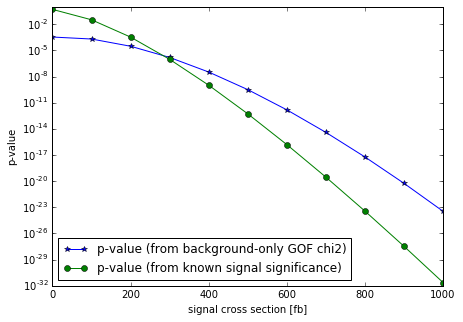

In [12]:
pvals = []
pvals_fromtoys = []
pvals_signif = []
gofs = []
exp_gofs = []
for sig_inj in sig_inj_vals:
    sig_inj_str = '%.3f'%sig_inj
    sig_inj_str = sig_inj_str.replace('.','p')
    # open file
    obs_gof_file = uproot.open('higgsCombineRatio_inj%s.GoodnessOfFit.mH120.root'%sig_inj_str)
    obs_gof = obs_gof_file['limit'].arrays('limit')['limit'][0]

    
    signif_file = uproot.open('higgsCombineRatio_inj%s.Significance.mH120.root'%sig_inj_str)
    pval_signif = signif_file['limit'].arrays('limit')['limit'][0]
    pvals_signif.append(pval_signif)
    
    #exp_gof_file = uproot.open('higgsCombineRatio_inj%i.GoodnessOfFit.mH120.123456.root'%sig_inj)
    #exp_gof = exp_gof_file['limit'].arrays('limit')['limit']
    #exp_gofs.append(exp_gof)
    
    ## get p-value from toys
    #n_extreme = len(exp_gof[exp_gof > obs_gof])
    #n_total = len(exp_gof)
    #pval_toys = 1.*n_extreme/n_total
    #pvals_fromtoys.append(pval_toys)
    
    # get p-value assuming chi2 dist (may not be valid)
    pval = rt.TMath.Prob(obs_gof,n_bins-1)
    pvals.append(pval)
    gofs.append(obs_gof)
    #print('sig inj = %.1f fb, gof = %.2f, p-value (from chi2) = %.6f, p-value (from toys) = %.6f'%(sig_inj*sig_xsec,obs_gof,pval,pval_toys))
    print('sig inj = %.1f fb, gof = %.2f, p-value (from chi2) = %e, p-value = %e(from signif)'%(sig_inj*sig_xsec,obs_gof,pval,pval_signif))
    
plt.figure(figsize=(7,5))
plt.plot(sig_inj_vals*sig_xsec,pvals,label='p-value (from background-only GOF chi2)',marker='*')
plt.plot(sig_inj_vals*sig_xsec,pvals_signif,label='p-value (from known signal significance)',marker='o')
#plt.plot(sig_inj_vals,pvals_fromtoys,label='p-value (from toys)')
#plt.semilogx()
plt.semilogy()
#plt.yscale('symlog')
plt.xlabel('signal cross section [fb]')
plt.ylabel('p-value')
plt.legend(loc='lower left')

In [ ]:
'''
exp_gof = exp_gofs[1]
obs_gof = gofs[1]
pval_toys = pvals_fromtoys[1]
pval = pvals[1]

bin_width = (max(exp_gof+[obs_gof])+np.std(exp_gof)-(min(exp_gof)-np.std(exp_gof)))/30.
exp_gof_hist = rt.TH1D('gof','gof',30,min(exp_gof)-np.std(exp_gof), max(exp_gof+[obs_gof])+np.std(exp_gof))
exp_gof_hist_gt = rt.TH1D('gof_gt','gof_gt',30,min(exp_gof)-np.std(exp_gof), max(exp_gof+[obs_gof])+np.std(exp_gof))
for g in exp_gof: 
    exp_gof_hist.Fill(g)
    if g > obs_gof: 
        exp_gof_hist_gt.Fill(g)
        
        
d = rt.TCanvas('d','d',500,400)
f = rt.TF1("chi2","%f*ROOT::Math::chisquared_pdf(x,%i,0)"%(exp_gof_hist.Integral()*bin_width,n_bins),min(exp_gof)-np.std(exp_gof),max(exp_gof+[obs_gof])+np.std(exp_gof))
tleg = rt.TLegend(0.48,0.6,0.88,0.7)
tleg.SetLineWidth(0)
exp_gof_hist.Draw('hist')
exp_gof_hist_gt.SetFillColor(rt.kBlue-10)
exp_gof_hist_gt.Draw('fhistsame')
f.Draw('same')
line = rt.TLine(obs_gof,0,obs_gof,exp_gof_hist.GetMaximum())
line.SetLineWidth(2)
line.Draw()
tleg.AddEntry(exp_gof_hist_gt,'p-value (from toys) = %.2f'%pval_toys)
tleg.AddEntry(f,'p-value (from chi2) = %.2f'%pval)
tleg.Draw()
d.Draw()
'''